In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
import seaborn as sns

In [1]:
from data import DATA_PATH

# EDA

In [53]:
def plot_acf_pacf(ts):
    # ACF и PACF
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(ts.dropna(), lags=40, ax=ax[0])
    plot_pacf(ts.dropna(), lags=40, ax=ax[1])
    plt.show()

def plot_ts(df, col, date_col):
    # Визуализация данных
    plt.figure(figsize=(8, 5))
    plt.plot(df[date_col].values, df[col].values)
    plt.title(f'{col} from 2020 to 2024')
    plt.xlabel('Date')
    plt.ylabel(f'{col}')
    plt.show()

def make_adf(ts):
    result = adfuller(ts.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print('Stationary ts, a=0.05')
    else:
        print('Not Stationary ts, a=0.05')

def plot_density(df, col):
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], stat = 'density')
    plt.title(f'Гистограмма {col}')

## Индекс РТС

In [28]:
data = pd.read_excel(DATA_PATH / 'imoex_rtf_rate/rtsi.xlsx')[::-1]
data.head()

,Date,RTSI
993,2020-01-03,1564.18
992,2020-01-06,1568.35
991,2020-01-08,1589.08
990,2020-01-09,1601.74
989,2020-01-10,1614.69


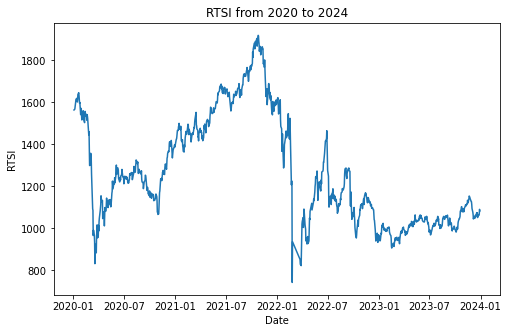

In [33]:
# Визуализация данных
plot_ts(data, 'RTSI', 'Date')

In [34]:
# Описательная статистика
print(data.describe())

                                Date         RTSI
count                            994   994.000000
mean   2022-01-02 22:05:33.199195136  1269.338370
min              2020-01-03 00:00:00   742.910000
25%              2020-12-29 06:00:00  1050.675000
50%              2021-12-20 12:00:00  1205.195000
75%              2023-01-09 18:00:00  1474.707500
max              2023-12-29 00:00:00  1919.580000
std                              NaN   257.062105


In [37]:
make_adf(data['RTSI'])

ADF Statistic: -2.462722
p-value: 0.124810
Not Stationary ts, a=0.05


Вывод: сам ряд не стационарен. Дифференцируем.

In [38]:
data['RTSI_diff']= data['RTSI'].diff()

In [39]:
make_adf(data['RTSI_diff'])

ADF Statistic: -13.507575
p-value: 0.000000
Stationary ts, a=0.05


Вывод: теперь стационарен

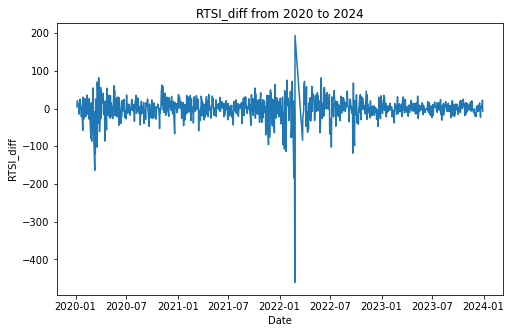

In [40]:
plot_ts(data, 'RTSI_diff', 'Date')

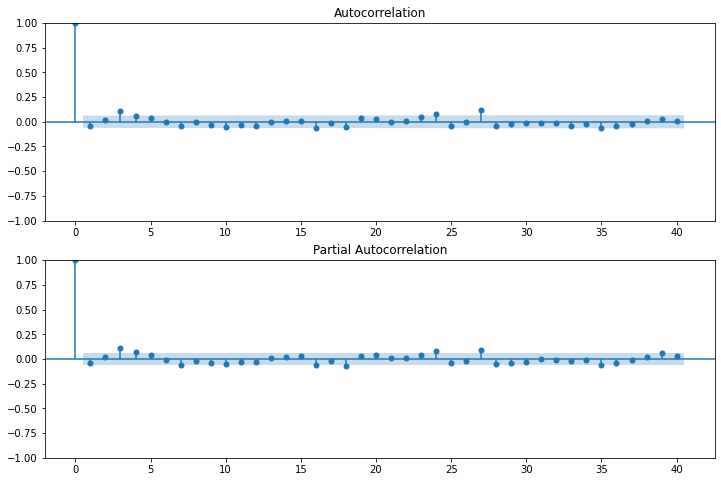

In [41]:
plot_acf_pacf(data['RTSI_diff'])

In [41]:
# Выбор параметров ARIMA
p = 1  # Количество лагов авторегрессии, основанное на PACF
d = 1  # Интегрирование, чтобы сделать данные стационарными
q = 1  # Количество лагов скользящего среднего, основанное на ACF

# Обучение модели ARIMA
model = ARIMA(data['RTSI'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   RTSI   No. Observations:                  994
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4803.356
Date:                Wed, 12 Jun 2024   AIC                           9612.712
Time:                        23:16:08   BIC                           9627.414
Sample:                             0   HQIC                          9618.302
                                - 994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7910      0.237      3.342      0.001       0.327       1.255
ma.L1         -0.7704      0.243     -3.171      0.002      -1.247      -0.294
sigma2       931.7075      9.258    100.641      0.0

## Валютные курсы

### USD

In [43]:
usd = pd.read_excel(DATA_PATH / 'imoex_rtf_curs/usd_rub.xlsx')

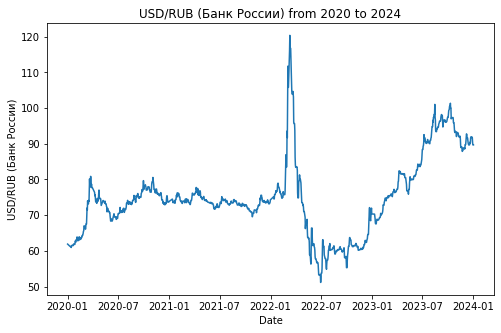

In [44]:
# Визуализация данных
plot_ts(usd, 'USD/RUB (Банк России)', 'Дата')

In [45]:
# Описательная статистика
print(usd.describe())

                                Дата  USD/RUB (Банк России)
count                           1186            1186.000000
mean   2022-01-13 05:44:49.376053760              75.081896
min              2020-01-01 00:00:00              51.158000
25%              2021-01-16 12:00:00              70.384700
50%              2022-01-17 12:00:00              73.933800
75%              2023-01-17 18:00:00              77.940600
max              2024-01-01 00:00:00             120.378500
std                              NaN              10.788006


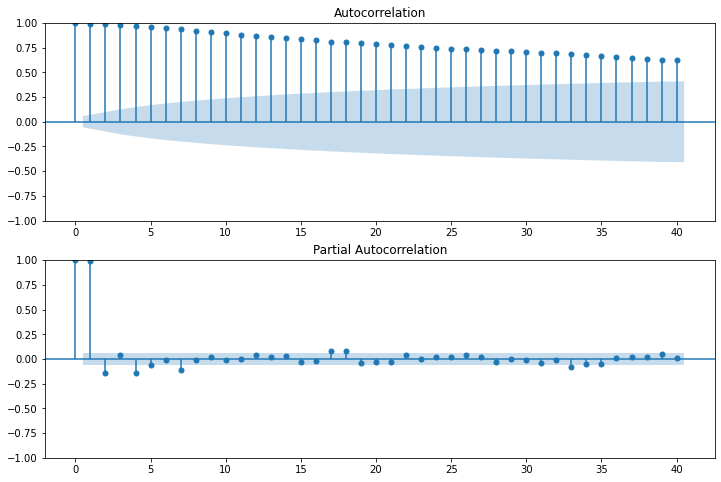

In [46]:
plot_acf_pacf(usd['USD/RUB (Банк России)'])

У исходного ряда точно видим нестационарность, но сезонности как будто бы нет (нет повторяющихся значимых лагов PACF). Проверим ADF тестом

In [47]:
make_adf(usd['USD/RUB (Банк России)'])

ADF Statistic: -2.372766
p-value: 0.149571
Not Stationary ts, a=0.05


Действительно, нестационарен, возьмем первые разности.

In [48]:
usd['usd_diff']= usd['USD/RUB (Банк России)'].diff()

In [49]:
make_adf(usd['usd_diff'])#стационарный

ADF Statistic: -8.106554
p-value: 0.000000
Stationary ts, a=0.05


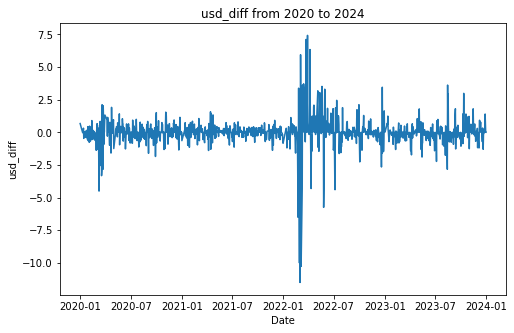

In [50]:
plot_ts(usd, 'usd_diff', 'Дата')

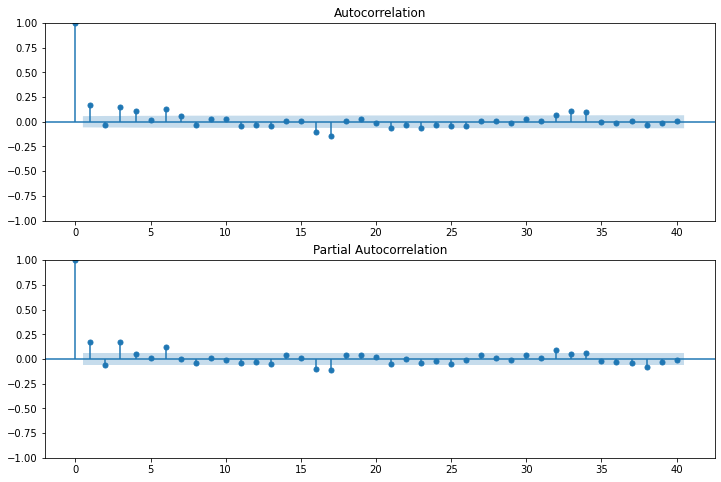

In [51]:
plot_acf_pacf(usd['usd_diff'])

Теперь все ок

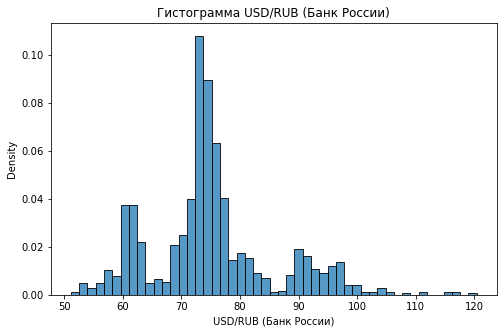

In [54]:
plot_density(usd, 'USD/RUB (Банк России)')

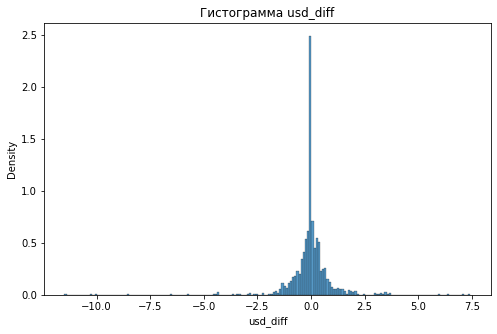

In [55]:
plot_density(usd, 'usd_diff')

Гистограмма стационарного ряда в первых разностях выглядит уже получше, но есть ощущение, что "тяжелые хвосты"

### EUR

In [24]:
eur = pd.read_excel(DATA_PATH / 'imoex_rtf_curs/eur_rub.xlsx')

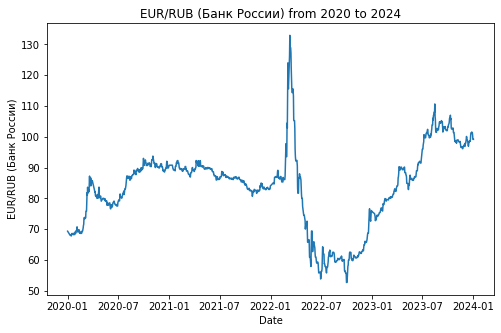

In [56]:
# Визуализация данных
plot_ts(eur, 'EUR/RUB (Банк России)', 'Дата')

In [57]:
# Описательная статистика
print(eur.describe())

                                Дата  EUR/RUB (Банк России)
count                           1186            1186.000000
mean   2022-01-13 05:44:49.376053760              83.765788
min              2020-01-01 00:00:00              52.737900
25%              2021-01-16 12:00:00              77.765600
50%              2022-01-17 12:00:00              86.464350
75%              2023-01-17 18:00:00              90.386000
max              2024-01-01 00:00:00             132.958100
std                              NaN              13.133186


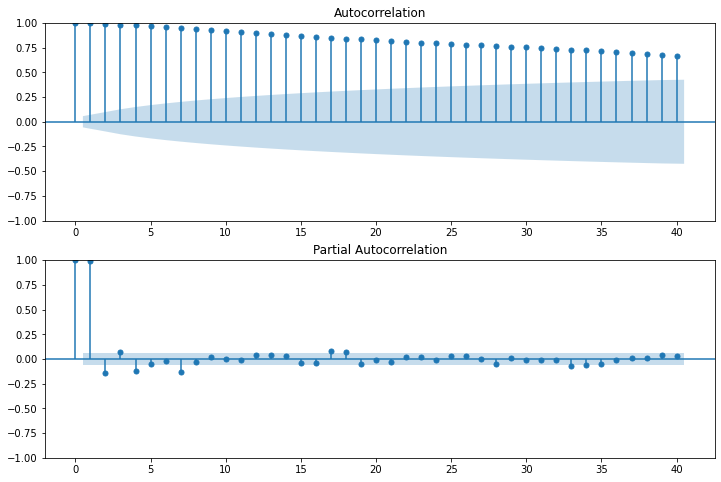

In [58]:
plot_acf_pacf(eur['EUR/RUB (Банк России)'])

Аналогично доллару, нет стационарности, но и сезонности нет

In [59]:
make_adf(eur['EUR/RUB (Банк России)']) 

ADF Statistic: -2.072403
p-value: 0.255755
Not Stationary ts, a=0.05


ADF тест подтверждает нестационарность, берем разности

In [60]:
eur['eur_diff']= eur['EUR/RUB (Банк России)'].diff()

In [61]:
make_adf(eur['eur_diff']) #ура

ADF Statistic: -8.317212
p-value: 0.000000
Stationary ts, a=0.05


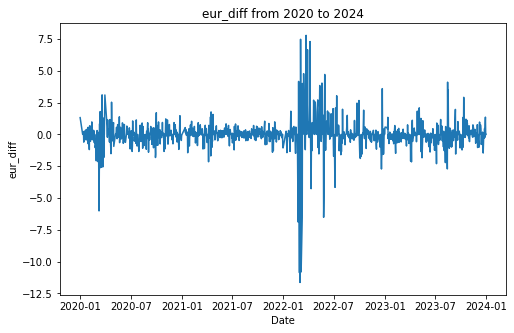

In [62]:
plot_ts(eur, 'eur_diff', 'Дата')

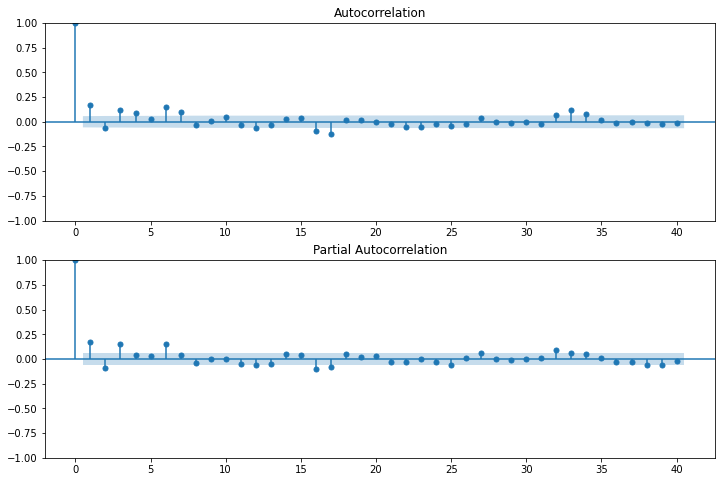

In [63]:
plot_acf_pacf(eur['eur_diff'])

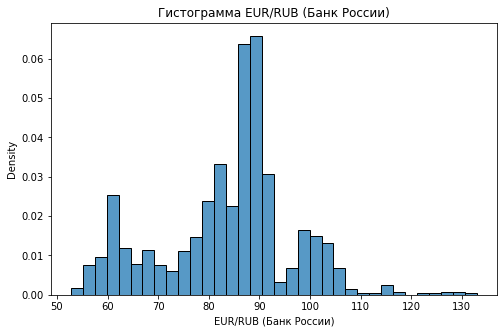

In [64]:
plot_density(eur, 'EUR/RUB (Банк России)')

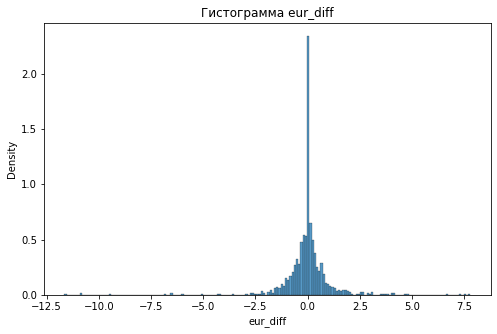

In [65]:
plot_density(eur, 'eur_diff')

Аналогично курсу доллара: в первых разностях похоже на нормальное распределение, но хвосты тяжелые + есть пик в нуле

## BRENT

In [73]:
data = pd.read_excel(DATA_PATH / 'imoex_rtf_rate/brent.xlsx').rename(columns={'Дата': 'date', 'Нефть Brent': 'brent'})

In [75]:
data.head()

,date,brent
0,2023-12-29,77.04
1,2023-12-28,77.15
2,2023-12-27,79.54
3,2023-12-26,81.07
4,2023-12-22,79.07


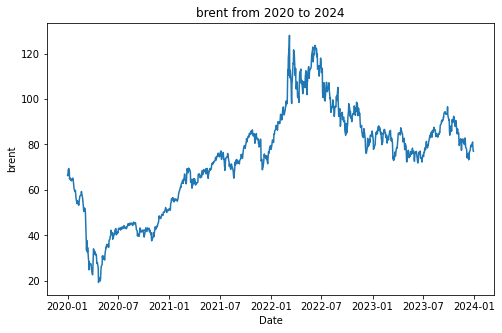

In [76]:
# Визуализация данных
plot_ts(data, 'brent', 'date')

In [77]:
# Описательная статистика
print(data.describe())

                                date        brent
count                           1036  1036.000000
mean   2021-12-29 09:27:06.254826240    73.796998
min              2020-01-01 00:00:00    19.330000
25%              2020-12-29 18:00:00    58.745000
50%              2021-12-29 12:00:00    76.530000
75%              2022-12-28 06:00:00    86.857500
max              2023-12-29 00:00:00   127.980000
std                              NaN    22.281245


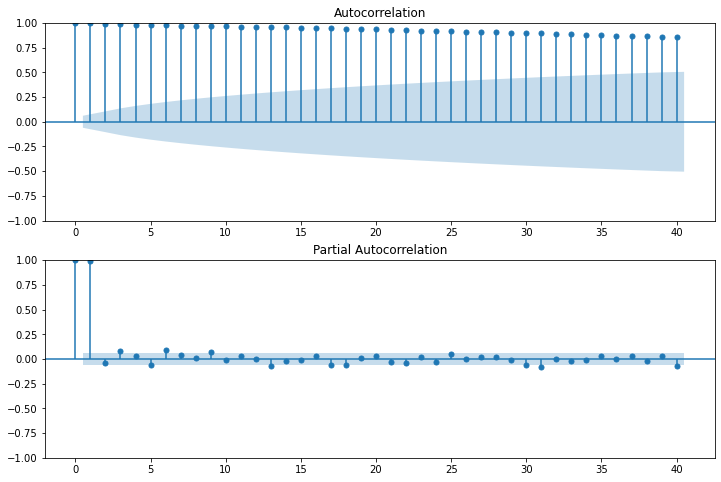

In [79]:
plot_acf_pacf(data['brent'])

In [78]:
make_adf(data['brent']) 

ADF Statistic: -1.140973
p-value: 0.698459
Not Stationary ts, a=0.05


In [80]:
data['brent_diff'] =data["brent"].diff()

In [81]:
make_adf(data['brent_diff']) 

ADF Statistic: -13.291797
p-value: 0.000000
Stationary ts, a=0.05


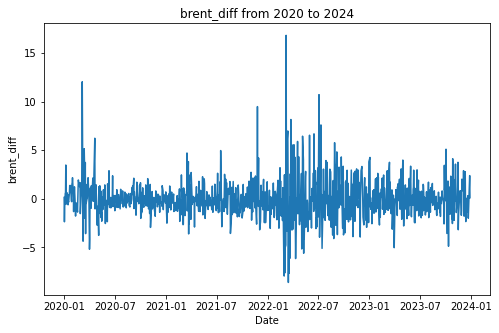

In [82]:
plot_ts(data, 'brent_diff', 'date')

Как и предыдущие, ряд стационарен только в первых разностях

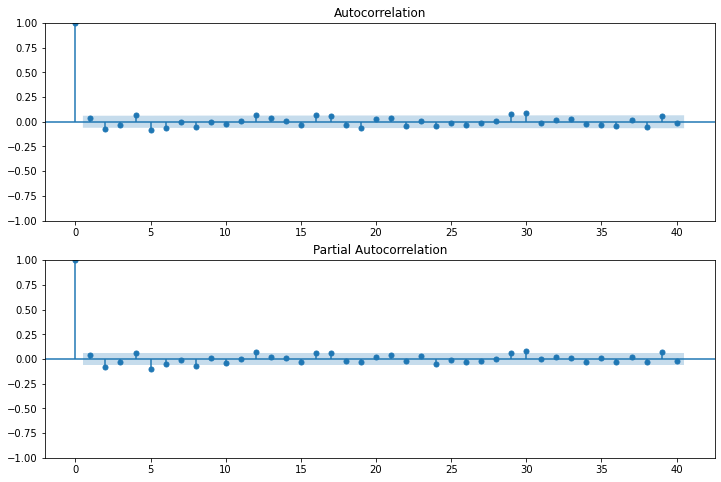

In [83]:
plot_acf_pacf(data['brent_diff'])

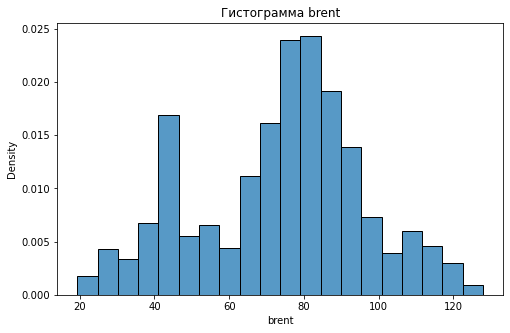

In [86]:
plot_density(data, 'brent') 

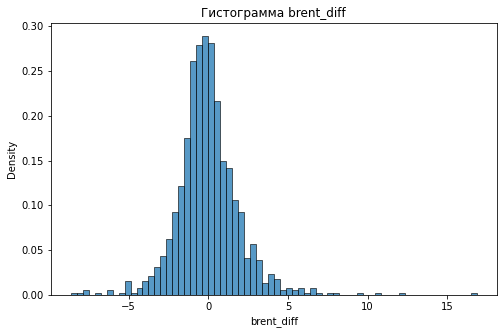

In [85]:
plot_density(data, 'brent_diff') 

Кажется, график распределения хороший